In [1]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader_frames import DataLoader

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

In [ ]:
data_loader = DataLoader('frame_17_point_centered.hdf5')
%matplotlib inline  
i=0
obj = []
for image, output in data_loader.load_all():
    if i==0:
        obj = plt.imshow(image[:,:,0])
    else:
        obj.set_data(image)
    plt.show()


In [2]:
#import modules
epochs = 35
batch_size = 200
base_learning_rate = 0.01
learning_decay_rate = 5
learning_decay_factor = 0.75
data_loader = DataLoader('frame_17_point_centered.hdf5')
data_loader.divide_data()

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, 260, 346, 3], name='input_image')
grount_truth = tf.placeholder(tf.float32, [None, 18], name='ground_truth')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.FullyConnectedCL(input_image, encoder=DlModels.Conv2Dx3, N_outputs=18)

#train_op, loss = TrainDL.SoftEntropy(nn_last_layer, grount_truth, learning_rate)
train_op, loss = TrainDL.SoftEntropy(nn_last_layer, grount_truth, learning_rate)

#accuracy
correct_prediction = tf.equal(tf.argmax(nn_last_layer, 1), tf.argmax(grount_truth, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
# Train NN using the train_nn function
tf.glorot_uniform_initializer()
TrainDL.train_nn(sess, epochs, nn_last_layer, batch_size, data_loader, accuracy_op, train_op, loss, input_image, grount_truth, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Training...

EPOCH 1 ...
Loss 614.1065216064453 ...
Train Accuracy 0.07630681758746505 ...
Validation Accuracy [0.04863222] ...
EPOCH 2 ...
Loss 553.6150207519531 ...
Train Accuracy 0.07695075869560242 ...
Validation Accuracy [0.04863222] ...
EPOCH 3 ...
Loss 522.4547653198242 ...
Train Accuracy 0.07630681851878762 ...
Validation Accuracy [0.04863222] ...
EPOCH 4 ...


KeyboardInterrupt: 

In [2]:
sess = tf.Session()
tf.disable_eager_execution()
saver = tf.train.import_meta_graph('./model.meta')
[n.name for n in tf.get_default_graph().as_graph_def().node]
g = tf.train.latest_checkpoint('./')
saver.restore(sess, tf.train.latest_checkpoint('./')) 

accuracy_op = tf.get_default_graph().get_tensor_by_name("accuracy_operation:0")

input_image = tf.get_default_graph().get_tensor_by_name("input_image:0")
grount_truth = tf.get_default_graph().get_tensor_by_name('ground_truth:0')
initial_hidden_state = tf.get_default_graph().get_tensor_by_name('initial_hidden_state:0')
initial_carry_state = tf.get_default_graph().get_tensor_by_name('initial_carry_state:0')
nn_last_layer = tf.get_default_graph().get_tensor_by_name("nn_last_layer:0")
hidden_state = tf.get_default_graph().get_tensor_by_name("hidden_state:0")
carry_state = tf.get_default_graph().get_tensor_by_name("carry_state:0")

INFO:tensorflow:Restoring parameters from ./model


In [3]:
sess = tf.Session()
tf.disable_eager_execution()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('./')) 

INFO:tensorflow:Restoring parameters from ./model


In [4]:
data_loader = DataLoader('test_centered_2.hdf5')
data_loader.divide_data(train_percentage=0.0, valid_percentage=0.0, test_percentage=1)
#data_loader.divide_data()
x_train, y_train, test_size = data_loader.get_test_data_sequence()
initial_state_value = np.zeros(shape=(test_size, 29, 39, 20), dtype=float)

test_accuracy = sess.run([accuracy_op],
                    feed_dict={input_image: x_train, grount_truth: y_train, initial_hidden_state: initial_state_value, initial_carry_state: initial_state_value})
print(test_accuracy)

[0.85714287]


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15  0  0  0  0  0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 0, 0, 0, 0]


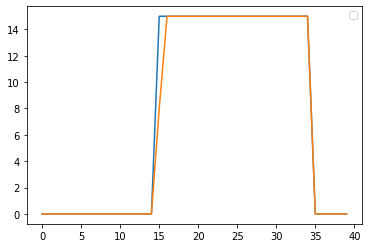

In [18]:
#Test step by step
z = []
idx = 14

x_train, y_train, test_size = data_loader.get_test_data_sequence()
final_hidden_state = []
final_carry_state = []

for i in range(len(x_train[idx])):
    if i==0:        
        initial_hidden_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
        initial_carry_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
    else:
        initial_hidden_state_value = final_hidden_state
        initial_carry_state_value = final_carry_state
    last_layer, final_hidden_state, final_carry_state = sess.run([nn_last_layer, hidden_state, carry_state], 
                                feed_dict={input_image: [[x_train[idx][i]]], initial_hidden_state: initial_hidden_state_value, initial_carry_state: initial_carry_state_value})
    #plt.imshow(x_train[idx][i])
    #plt.show()
    g = np.argmax(last_layer.reshape(-1), 0)    
    z.append(g)
    
print(np.argmax(y_train[idx, :, :], axis=1))
print(z)
plt.plot(np.argmax(y_train[idx, :, :], axis=1))
plt.plot(z)
plt.legend('true', 'lstm')
plt.show()
    
    

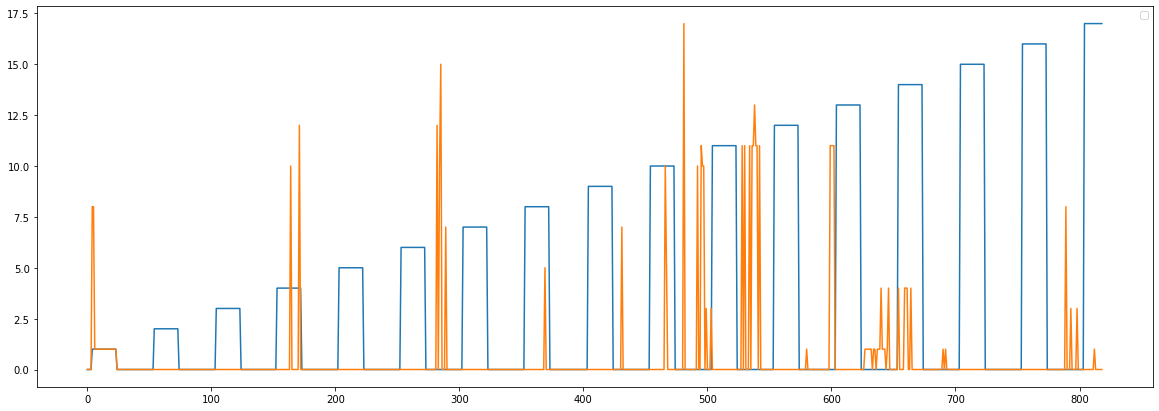

In [9]:
#run full sequence

initial_hidden_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
initial_carry_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)

truth_list = []
prediction_list = []
prev_truth = 0
fall_counter = 0
initiate_counter = False

for image, contact_status in data_loader.get_full_data_sequence():
    
    #print(np.shape(image))
    
    last_layer, final_hidden_state, final_carry_state = sess.run([nn_last_layer, hidden_state, carry_state], 
                                feed_dict={input_image: image, initial_hidden_state: initial_hidden_state_value, initial_carry_state: initial_carry_state_value})
        
    truth_list.append(contact_status) 
    prev_truth = contact_status
    
    
    prediction = np.argmax(last_layer.reshape(-1), 0)   
    prediction_list.append(prediction)


    if (prev_truth > 0) and contact_status==0:
        initiate_counter = True

    if initiate_counter and contact_status==0:
        fall_counter = fall_counter + 1
    elif contact_status!=0:
        initiate_counter = False
        fall_counter = 0

    if fall_counter > 4:
        initial_hidden_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
        initial_carry_state_value = np.zeros(shape=(1, 29, 39, 20), dtype=float)
        initiate_counter = False
        fall_counter = 0
    else:        
        initial_hidden_state_value = final_hidden_state    
        initial_carry_state_value = final_carry_state
    

plt.figure(figsize=(20,7))
plt.plot(truth_list)
plt.plot(prediction_list)
plt.legend('true', 'lstm')
plt.show()

In [ ]:
plt.imshow(x_train[idx][0])

In [ ]:
print(g.eval())

In [ ]:
x = tf2.ones(shape=(5, 3, 5))
print(tf.shape(x))
print(tf.shape(x[:,-1,:]))

In [5]:
logits = [[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]
labels = [[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]]
tf2.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)



<tf.Tensor 'softmax_cross_entropy_with_logits_1/Reshape_2:0' shape=(2,) dtype=float32>